In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde as GKDE

from scipy.stats import multivariate_normal
from scipy.stats import norm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.weightedEDFs as wEDFs
import src.binning as binning

import random

import matplotlib.patches as patches

import seaborn as sns

from mpl_toolkits import mplot3d
import matplotlib as mpl

# Fluid Flow Example

This notebook covers the example described in Section 5.2 of the paper.

In [2]:
plot_directory = './plots'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5


CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 

In [3]:
random.seed(20)
np.random.seed(17)

In [4]:
def rejection_sampling(r):
    
    unifs = np.random.uniform(0,1,len(r))
    M = np.max(r)
    
    return (unifs < (r / M))

The data is generated as described in Section 5.2. Resulting data is stored for use in this notebook in the data directory. We load the data and visualize it below.

In [5]:
start_data = np.genfromtxt('./data/streams-initial-start.dat',
                           dtype=[('float'),('float'),('float')])
init_samples_full = []
for i in start_data:
    init_samples_full.append([i[0], i[1], i[2]])
init_samples_full = np.array(init_samples_full)

In [6]:
finish_data = np.genfromtxt('./data/streams-initial-finish.dat',
                            dtype=[('float'),('float'),('float')])
pred_samples_full = []
for i in finish_data:
    pred_samples_full.append([i[0], i[1], i[2]])
pred_samples_full = np.array(pred_samples_full)

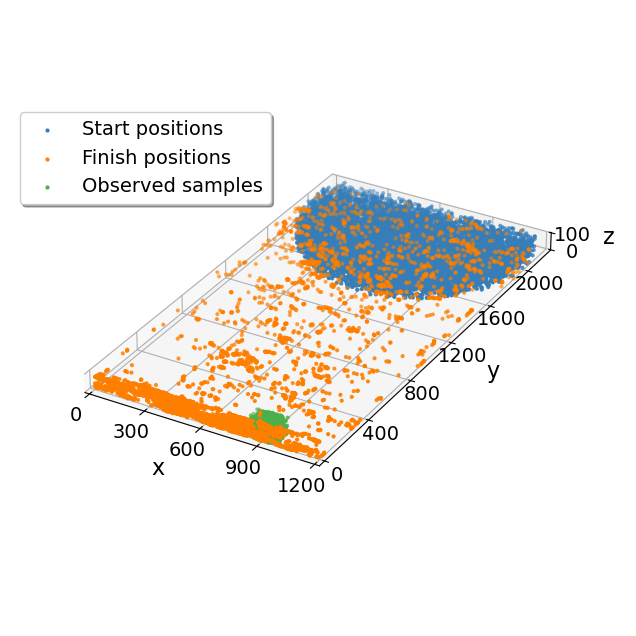

In [26]:
fig = plt.figure(figsize=(10,8));
ax = fig.add_subplot(projection='3d');
ax.scatter(init_samples_full[:,0], init_samples_full[:,1], init_samples_full[:,2],
           label='Start positions', s=4);
ax.scatter(pred_samples_full[:,0], pred_samples_full[:,1], pred_samples_full[:,2],
           label='Finish positions', s=4, zorder=1);
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           label='Observed samples', s=4, zorder=10);
ax.set_ylim(0, 2200);
ax.set_xlim(0, 1200);
ax.set_zlim(0, 100);
ax.set_xlabel('x', labelpad=15)
ax.set_ylabel('y', labelpad=30, va='top')
ax.set_zlabel('\nz', labelpad=10)
ax.set_xticks([0,300,600,900,1200]);
ax.set_xticklabels([0,300,600,900,1200]);
ax.set_yticks([0,400,800,1200,1600,2000]);
ax.set_yticklabels([0,400,800,1200,1600,2000]);
ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), shadow=True);
ax.set_zticks([0,100]);
ax.set_zticklabels([0,100]);
ax.set_box_aspect([1.0, 1.83, 0.08], zoom=0.86);
ax.zaxis.set_rotate_label(False)

plt.savefig(f'{plot_directory}/fluid_flow_start_end.png', bbox_inches='tight');

Here, we extract the predicted and observed samples, which are the samples that are within 100 ft of the end of the domain.

In [8]:
pred_samples = pred_samples_full[pred_samples_full[:,1] < 100, :1]
init_samples = init_samples_full[pred_samples_full[:,1] < 100, :]
n_init_samples = len(init_samples)

print(n_init_samples)

6467


This creates a set of 6467 initial/predicted samples.

The observed distribution is normal. We generate a set of 10k observed samples.

In [9]:
n_obs_samples = 10000

obs_dist = norm(900, 25)

obs_samples = obs_dist.rvs((n_obs_samples,1))

In [10]:
pred_KDE = GKDE(pred_samples.T)
obs_KDE = GKDE(obs_samples.T)
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
PF_update_KDE = GKDE(pred_samples.T, weights=rn_w)

print(f'E(r) = {np.mean(r)}')

E(r) = 1.069021112535409


Below, we plot the observed and predicted distributions on the data space. We can see that the observed distribution is quite sharp in comparison to the predicted, and the bulk of the density falls in the tail of the predicted.

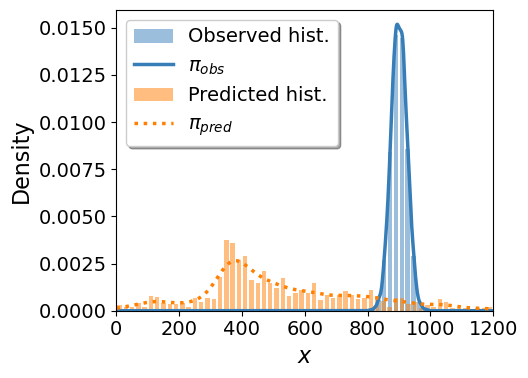

In [11]:
plt.hist(obs_samples, bins=10, density=True, label='Observed hist.', alpha=0.5, rwidth=0.8, color=CB_color_cycle[0]);
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000);
plt.plot(xx, obs_KDE.pdf(xx), label=r'$\pi_{obs}$', c=CB_color_cycle[0]);
plt.hist(pred_samples, bins=60, density=True, label='Predicted hist.', alpha=0.5, rwidth=0.7, color=CB_color_cycle[1]);
plt.plot(xx, pred_KDE.pdf(xx), label=r'$\pi_{pred}$', c=CB_color_cycle[1], ls=':');
plt.xticks(ticks=np.linspace(np.min(xx), np.max(xx), 7),
           labels=["{:.0f}".format(x) for x in np.linspace(np.min(xx), np.max(xx), 7)]);
plt.xlim(np.min(xx), np.max(xx));
plt.xlabel(r'$x$');
plt.ylabel('Density');
plt.legend(shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/fluid_flow_samples.png', bbox_inches='tight');

For comparison, we find the solution using the density-based method and plot the results below. Note that the $r$ value for this example is fairly close to $1$, indicating that there should not be a significant issue with predictability.

In [12]:
pred_KDE = GKDE(pred_samples.T)
obs_KDE = GKDE(obs_samples.T)
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
PF_update_KDE = GKDE(pred_samples.T, weights=rn_w)

print(f'E(r) = {np.mean(r)}')

E(r) = 1.069021112535409


In [13]:
update_inds = rejection_sampling(rn_w)

update_samples = init_samples[update_inds]
n_update_samples = len(update_samples)

pf_samples = pred_samples[update_inds]

pf_KDE = GKDE(pf_samples.T)

Next, we compute the solution and visualize the results using the binning (with K-means) method.

In [14]:
n_clusters = 100
w, labels, centers, w_cluster = binning.computePartitionedWeights_kMeans_IID(init_samples,
                                                                             pred_samples,
                                                                             sample_set_2=obs_samples,
                                                                             n_clusters=n_clusters)

     pcost       dcost       gap    pres   dres
 0: -3.9081e-02 -1.0020e+02  1e+02  4e-16  2e+01
 1: -3.9297e-02 -1.2003e+00  1e+00  2e-15  2e-01
 2: -5.3914e-02 -1.9484e-01  1e-01  2e-15  3e-02
 3: -1.0609e-01 -1.9105e-01  8e-02  4e-15  1e-17
 4: -1.1242e-01 -1.2346e-01  1e-02  3e-15  9e-18
 5: -1.1569e-01 -1.1848e-01  3e-03  6e-15  7e-18
 6: -1.1645e-01 -1.1699e-01  5e-04  4e-15  1e-17
 7: -1.1663e-01 -1.1672e-01  1e-04  1e-14  7e-18
 8: -1.1666e-01 -1.1668e-01  2e-05  5e-15  1e-17
 9: -1.1667e-01 -1.1667e-01  4e-06  7e-15  1e-17
10: -1.1667e-01 -1.1667e-01  1e-06  5e-15  7e-18
11: -1.1667e-01 -1.1667e-01  2e-07  2e-15  8e-18
12: -1.1667e-01 -1.1667e-01  5e-08  5e-15  8e-18
Optimal solution found.


Here, we plot the push-forward of the distributions-based solution, as a weighted EDF on the data space.

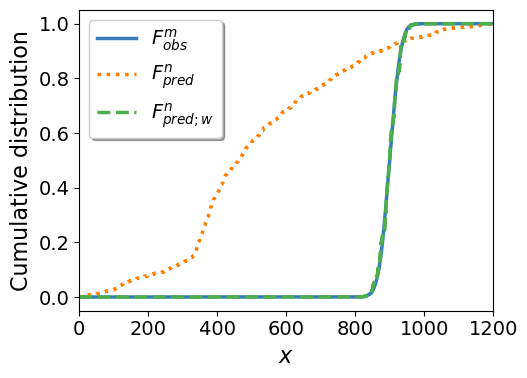

In [15]:
isort = np.argsort(pred_samples[:,0])
isort_obs = np.argsort(obs_samples[:,0])

plt.step(np.append(0, np.append(obs_samples[isort_obs], [np.max(pred_samples)])),
         np.append(0, np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), [1])),
         label=r'$F^m_{obs}$');
plt.step(pred_samples[isort], np.cumsum([1/n_init_samples]*n_init_samples),
         label=r'$F^n_{pred}$', ls=':');
plt.step(pred_samples[isort], np.cumsum(w[isort]),
         label=r'$F^n_{pred;w}$', ls='--');
plt.xticks(ticks=[0,200,400,600,800,1000,1200],
           labels=[0,200,400,600,800,1000,1200]);
plt.xlim(0,1200);

plt.xlabel(r'$x$');
plt.ylabel('Cumulative distribution');
plt.legend(loc='upper left', shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/fluid_flow_kmeans_cdfs.png', bbox_inches='tight');

To compare, we plot the push-forward of the update (the density-based solution) as a weighted KDE on the data space.

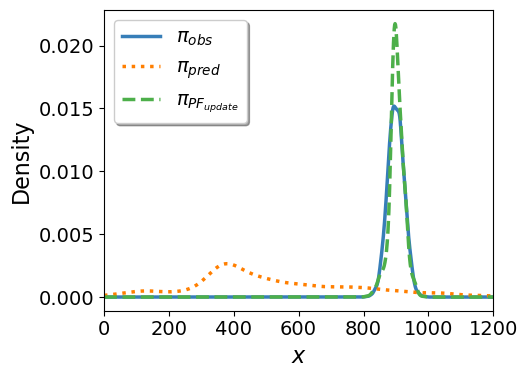

In [16]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)
kmeans_KDE = GKDE(pred_samples[:,0], weights=rn_w)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$');
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$', ls=':');
plt.plot(xx, kmeans_KDE(xx), label=r'$\pi_{PF_{update}}$', ls='--');
plt.xticks(ticks=[0,200,400,600,800,1000,1200],
           labels=[0,200,400,600,800,1000,1200]);
plt.xlim(0,1200);

plt.xlabel(r'$x$');
plt.ylabel('Density');
plt.legend(loc='upper left', shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/fluid_flow_kmeans_pdfs.png', bbox_inches='tight');

We note that the density-based solution pushes forward to a distribution that clearly does not match the observed as well as the push-forward of the distributions-based solution did. Several plots will help us to investigate and understand this matter further.

First, we will plot the density-based (Radon-Nikodym) and the distribution-based weights against each other directly.

(-0.001, 0.0065)

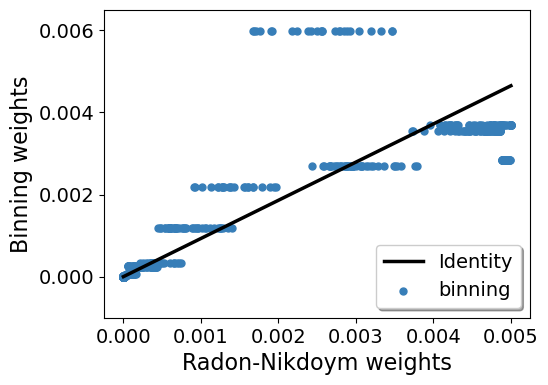

In [17]:
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k', label='Identity')

plt.xlabel('Radon-Nikdoym weights');
plt.ylabel('Binning weights');
plt.scatter(rn_w, w, label=f'binning')
plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(w), np.max(rn_w), 6)]);
plt.legend(shadow=True, loc='lower right', bbox_to_anchor=(1., 0.));
plt.ylim(-0.001, 0.0065)

While the majority of the bins do fall roughly along the identity line, indicating a similarity of the computed weights between the methods in each region, there are two clear outliers, which we highlight below (the indices of the outlying bins was found previously by experimentation).

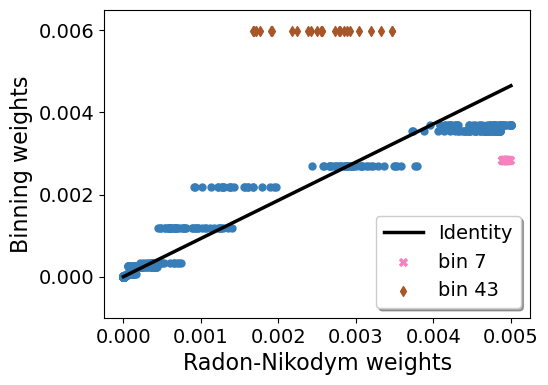

In [23]:
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k', label='Identity')

plt.xlabel('Radon-Nikodym weights');
plt.ylabel('Binning weights');
for label in np.unique(labels):
    if label != 7 and label != 43:
        plt.scatter(rn_w[(labels==label)], w[(labels==label)], color=CB_color_cycle[0])
plt.scatter(rn_w[(labels==7)], w[(labels==7)], label=f'bin 7', marker='x', color=CB_color_cycle[3]);
plt.scatter(rn_w[(labels==43)], w[(labels==43)], label=f'bin 43', marker='d', color=CB_color_cycle[4]);
plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(w), np.max(rn_w), 6)]);
plt.ylim(-0.001, 0.0065)
plt.legend(shadow=True, loc='lower right', bbox_to_anchor=(1., 0.));
plt.savefig(f'{plot_directory}/fluid_flow_weights.png', bbox_inches='tight')

We provide a zoomed-in density plot to gain more understanding of which regions are causing differences between the methods, highlighting the regions covered by the outlying bins.

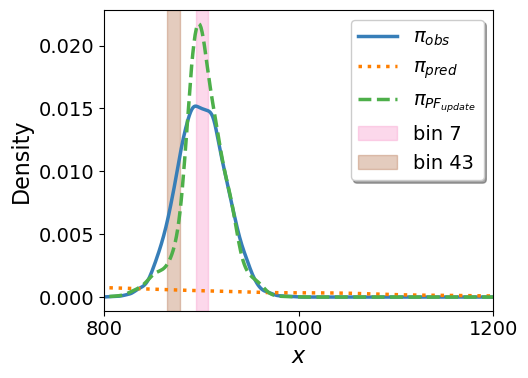

In [19]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)

low_b7 = np.min(pred_samples[(labels==7),0])
upp_b7 = np.max(pred_samples[(labels==7),0])
low_b43 = np.min(pred_samples[(labels==43),0])
upp_b43 = np.max(pred_samples[(labels==43),0])

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$');
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$', ls=':');
plt.plot(xx, PF_update_KDE(xx), label=r'$\pi_{PF_{update}}$', ls='--');
plt.axvspan(low_b7, upp_b7, alpha=0.3, label='bin 7', color=CB_color_cycle[3]);
plt.axvspan(low_b43, upp_b43, alpha=0.3, label='bin 43', color=CB_color_cycle[4]);
plt.xticks(ticks=[0,200,400,600,800,1000,1200],
           labels=[0,200,400,600,800,1000,1200]);
plt.xlim(800,1200);

plt.xlabel(r'$x$');
plt.ylabel('Density');
plt.legend(loc='upper right', shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/fluid_flow_density-bins.png', bbox_inches='tight');

This plot gives us some additional understanding of the mismatch between the density and distributions-based methods for this example. We discuss some below.

First, the observed distribution falls within the tail of the predicted. Although there are roughly ~6500 predicted samples, very few of these samples fall within the support of the majority of the observed, meaning that this is essentially a low-sample number problem. A very large number of predicted samples would be needed to obtain enough samples in this tail end.

Second, which is related to the first, the KDE estimation of the predicted density is essentially a global solution over the whole data space. While it may be true that overall the KDE is a good representation of the density of the samples, within the observed region, it is not, which is a known issue with KDEs. When the densities of the samples are significantly different in different regions, the KDE may not be a good representation of the data.

Finally, the outlying bins also fall in regions where the observed density is rapidly changing. This means that issues in the predicted KDE can be magnified when computing the Radon-Nikodym weights as a ratio of KDEs in these regions.

It is interesting to observe as well that for the density-based method, outlying bin #43 gives an underestimate of the Radon-Nikodym weights, whereas the density-based method for outlying bin #7 gives an overestimate, as shown in the weights comparison figure. In the zoomed-in figure, we can see this directly shown, where $\pi_{PF_{update}}$ underestimates the observed in bin #43, and overestimates in bin #7.

The distributions-based method does not suffer from these same issues, and is a near-perfect match the the observed.

Below, we plot the solutions for both the density and distributions-based methods as weights on the initial samples in the parameter space. Although the solutions look similar upon a first glance, there are clearly more high values of weights from the distribution-based method.

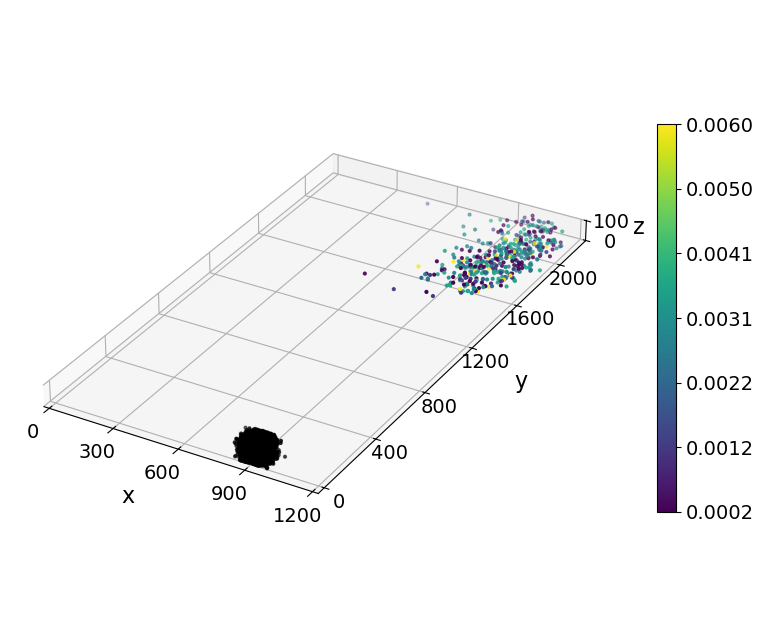

In [20]:
fig = plt.figure(figsize=(10,8));
ax = fig.add_subplot(projection='3d');

tolerance = 0.0001

p = ax.scatter(init_samples[w > tolerance,0], init_samples[w > tolerance,1], init_samples[w>tolerance,2],
               c=w[w > tolerance], label='Start positions', s=4);
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', label='Finish positions', s=4);

ax.set_ylim(0, 2200);
ax.set_xlim(0, 1200);
ax.set_zlim(0, 100);
ax.set_xlabel('x', labelpad=15)
ax.set_ylabel('y', labelpad=30, va='top')
ax.set_zlabel('\nz', va='top', labelpad=4)
ax.set_xticks([0,300,600,900,1200]);
ax.set_xticklabels([0,300,600,900,1200]);
ax.set_yticks([0,400,800,1200,1600,2000]);
ax.set_yticklabels([0,400,800,1200,1600,2000]);
ax.set_zticks([0,100]);
ax.set_zticklabels([0,100]);

cbar = fig.colorbar(p, ax=ax, fraction=0.025, pad=0.04);
cbar.set_ticks(np.linspace(np.min(w[w > tolerance]), np.max(w[w > tolerance]), 7));
cbar.ax.set_yticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(w[w > tolerance]), np.max(w[w > tolerance]), 7)]);

ax.set_box_aspect([1.0, 1.83, 0.08]);

plt.savefig(f'{plot_directory}/fluid_flow_kmeans_weights.png', bbox_inches='tight');

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_71407/228691893.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


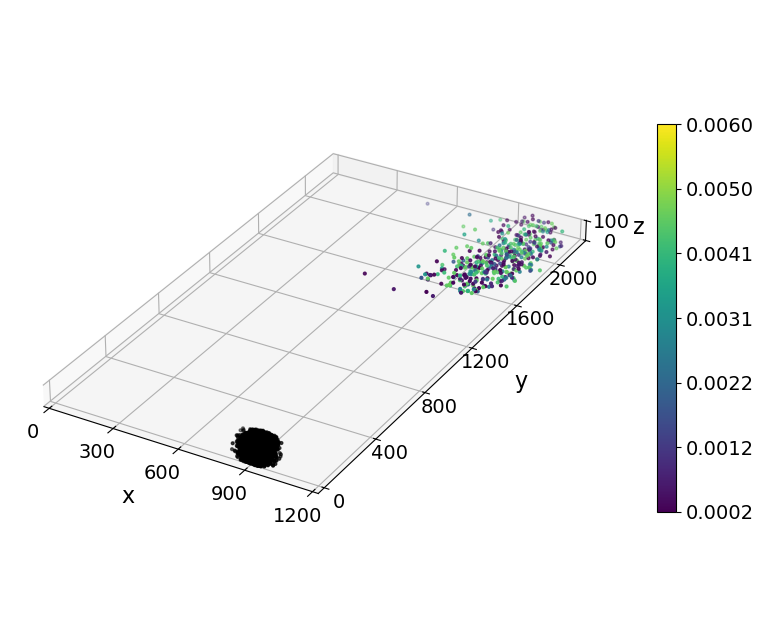

In [21]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection='3d')

p = ax.scatter(init_samples[rn_w > tolerance,0], init_samples[rn_w > tolerance,1], init_samples[rn_w > tolerance,2],
               c=rn_w[rn_w > tolerance], s=4, vmin=np.min(w[w > tolerance]), vmax=np.max(w[w > tolerance]))
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', s=4)

ax.set_xlabel('x', labelpad=15)
ax.set_ylabel('y', labelpad=30, va='top')
ax.set_zlabel('\nz', va='top', labelpad=4)
ax.set_ylim(0, 2200)
ax.set_xlim(0, 1200)
ax.set_zlim(0, 100)
ax.set_xticks([0,300,600,900,1200])
ax.set_xticklabels([0,300,600,900,1200])
ax.set_yticks([0,400,800,1200,1600,2000])
ax.set_yticklabels([0,400,800,1200,1600,2000])
ax.set_zticks([0,100])
ax.set_zticklabels([0,100])

cbar = fig.colorbar(p, ax=ax, fraction=0.025, pad=0.04)
cbar.set_ticks(np.linspace(np.min(w[w > tolerance]), np.max(w[w > tolerance]), 7));
cbar.ax.set_yticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(w[w > tolerance]), np.max(w[w > tolerance]), 7)]);

ax.set_box_aspect([1.0, 1.83, 0.08])

plt.tight_layout()
plt.savefig(f'{plot_directory}/fluid_flow_rn_weights.png', bbox_inches='tight')

Finally, we plot the marginals of the solution and compare the methods below.

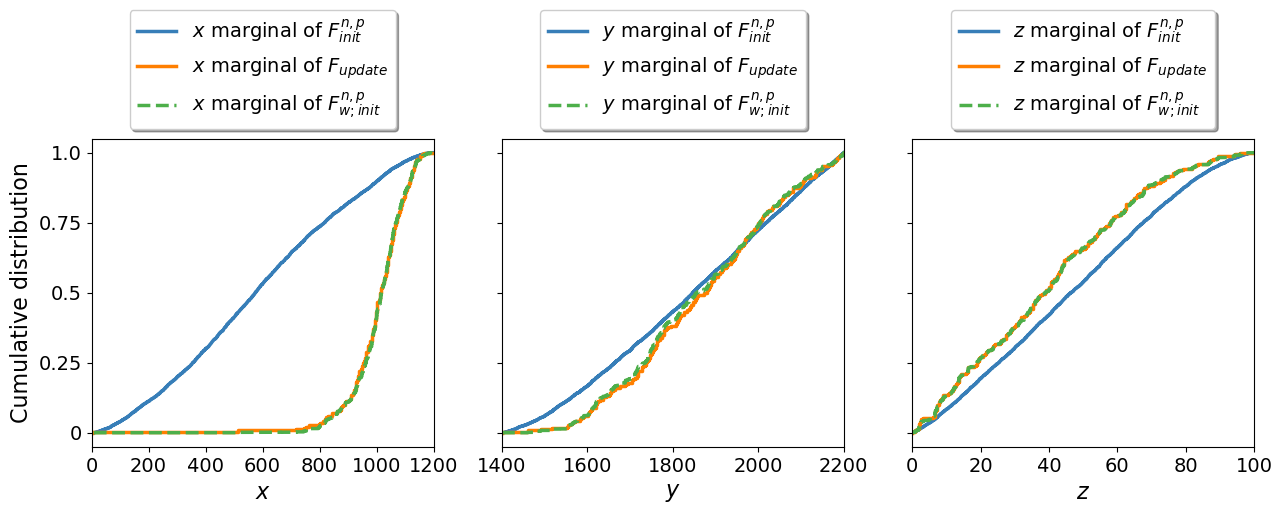

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,4));

isort = np.argsort(init_samples[:,0])
isort_up = np.argsort(update_samples[:,0])
ax1.set_ylabel('Cumulative distribution');

# x -------------------------------------------
ax1.step(init_samples[isort,0], np.cumsum([1/n_init_samples]*n_init_samples),
         label='$x$ marginal of $F^{n,p}_{init}$');
ax1.step(np.append(0, np.append(update_samples[isort_up,0], [np.max(init_samples[:,0])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label='$x$ marginal of $F_{update}$');
ax1.step(init_samples[isort,0], np.cumsum(w[isort]),
         label='$x$ marginal of $F^{n,p}_{w;init}$', ls='dashed');
ax1.set_xticks([0,200,400,600,800,1000,1200]);
ax1.set_xticklabels([0,200,400,600,800,1000,1200]);
ax1.set_xlim(0,1200);
ax1.set_yticks([0,0.25, 0.5, 0.75, 1.0]);
ax1.set_yticklabels([0,0.25, 0.5, 0.75, 1.0]);

ax1.set_xlabel(r'$x$');

ax1.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

# y -----------------------------------
isort = np.argsort(init_samples[:,1])
isort_up = np.argsort(update_samples[:,1])

ax2.step(np.append(1400, init_samples[isort,1]), np.append(0,np.cumsum([1/n_init_samples]*n_init_samples)),
         label='$y$ marginal of $F^{n,p}_{init}$');
ax2.step(np.append([1400], np.append(update_samples[isort_up,1], [np.max(init_samples[:,1])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label='$y$ marginal of $F_{update}$');
ax2.step(np.append(1400, init_samples[isort,1]), np.append(0, np.cumsum(w[isort])),
         label='$y$ marginal of $F^{n,p}_{w;init}$', ls='dashed');
ax2.set_xticks([1400,1600,1800,2000,2200]);
ax2.set_xticklabels(labels=[1400,1600,1800,2000,2200]);
ax2.set_xlim(1400,2200);

ax2.set_xlabel(r'$y$');

ax2.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

# z -----------------------------------
isort = np.argsort(init_samples[:,2])
isort_up = np.argsort(update_samples[:,2])

ax3.step(init_samples[isort,2], np.cumsum([1/n_init_samples]*n_init_samples),
         label='$z$ marginal of $F^{n,p}_{init}$');
ax3.step(np.append([np.min(init_samples[:,2])], np.append(update_samples[isort_up,2], [np.max(init_samples[:,2])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label='$z$ marginal of $F_{update}$');
ax3.step(init_samples[isort,2], np.cumsum(w[isort]),
         label='$z$ marginal of $F^{n,p}_{w;init}$', ls='dashed');

ax3.set_xticks([0,20,40,60,80,100]);
ax3.set_xticklabels(labels=[0,20,40,60,80,100]);
ax3.set_xlim(0,100);
ax3.set_xlabel(r'$z$');

ax3.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));